# PROJECT 13 - SERIES TEMPORALES / SWEET LIFT TAXI

## 1 Descripción del Proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### 1.1 Instrucciones del Proyecto

1. Descarga los datos y remuestréalos de tal forma que cada punto de datos de los datos originales caigan dentro de intervalos de una hora.
2. Analiza los datos.
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

### 1.2 Descripción de los Datos

Los datos se almacenan en el archivo /datasets/taxi.csv.  

El número de pedidos está en la columna `num_orders` 

### 1.3 Objetivos del Proyecto

- Predecir la cantidad de pedidos de taxis para la próxima hora. 
- Construye un modelo para dicha predicción.
- La métrica RECM en el conjunto de prueba no debe ser superior a 48.

### 1.4 Evaluación del Proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles fueron tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código limpio?

## 2 Preparación de los Datos

### 2.1 Importar Librerías

In [79]:
# Importar las librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error, make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import randint as sp_randInt
from scipy.stats import uniform as sp_randFloat

from pmdarima import auto_arima
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

### 2.2 Cargar y Leer los Datos

In [80]:
# Cargar el archivo y establecer la columna con la fecha y hora como index
df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])


In [81]:
# Asegurar que los índices estén ordenados
df.sort_index(inplace=True)
df.index.is_monotonic_increasing

True

In [82]:
# Crear una función para cargar la información general de los datos
def data_info(df, col):
    print('Data Head')
    display(df.head())
    print('='*100)
    print()
    
    print('Data Tail')
    display(df.tail())
    print('='*100)
    print()
    
    print('Data Min & Max')
    print('First Data is', df.index.min())
    print('Last Data is', df.index.max())
    
    print('Data Shape')
    display(df.shape)
    print('='*100)
    print()
    
    print('Data Info')
    display(df.info())
    print('='*100)
    print()
    
    print('Data Describe')
    display(df.describe())
    print('='*100)
    print()
    
    print('Duplicate Data')
    display(df.duplicated().sum())
    print('='*100)
    print()
    
    print('Unique Values')
    display(df[col].nunique())
    print(sorted(df[col].unique()))
    print('='*100)
    print()
    
    print('Missing Values')
    display(df.isna().sum())
    print('*'*100)

In [83]:
# Implementar la función y cargar los datos
data_info(df, 'num_orders')

Data Head


num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32


Data Tail


num_orders
datetime                       
2018-08-31 23:10:00          32
2018-08-31 23:20:00          24
2018-08-31 23:30:00          27
2018-08-31 23:40:00          39
2018-08-31 23:50:00          53


Data Min & Max
First Data is 2018-03-01 00:00:00
Last Data is 2018-08-31 23:50:00
Data Shape


(26496, 1)


Data Info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None


Data Describe


num_orders
count 26496.00000
mean     14.07046
std       9.21133
min       0.00000
25%       8.00000
50%      13.00000
75%      19.00000
max     119.00000


Duplicate Data


26415


Unique Values


81

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 71, 76, 78, 80, 81, 82, 87, 90, 91, 94, 95, 98, 99, 119]

Missing Values


num_orders    0
dtype: int64

****************************************************************************************************


**Hallazgos**
- Los datos están en orden monótonamente ascendente basados en la característica `datetime`.
- Transformamos el formato de los datos convirtiendo la columna `datetime` a datetime64 y la configuramos como el índice, dejando solo la característica `num_orders`.
- El conjunto de datos contiene 26,496 filas con 26,415 entradas duplicadas, lo cual es razonable dado que hay una sola característica y 81 valores únicos.
- El número de pedidos se registra a intervalos de 10 minutos.
- Los datos cubren un período del 1 de marzo de 2018 al 31 de agosto de 2018, abarcando 6 meses.
- No hay valores faltantes en el conjunto de datos.
- El tamaño del conjunto de datos es relativamente pequeño, solo 414 KB.
- Los valores promedio y mediano de los datos de `num_orders` son cercanos, con 14.07 y 13.00 respectivamente, lo que indica una distribución relativamente uniforme.
- El número de pedidos varía entre 0 y 119, con algunos intervalos sin pedidos de taxis y otros alcanzando un pico de 119.

## 3 Análisis

En la siguiente etapa, analizaremos las características del dataset.

### 3.1 Análisis de Tendencias y Estacionalidad

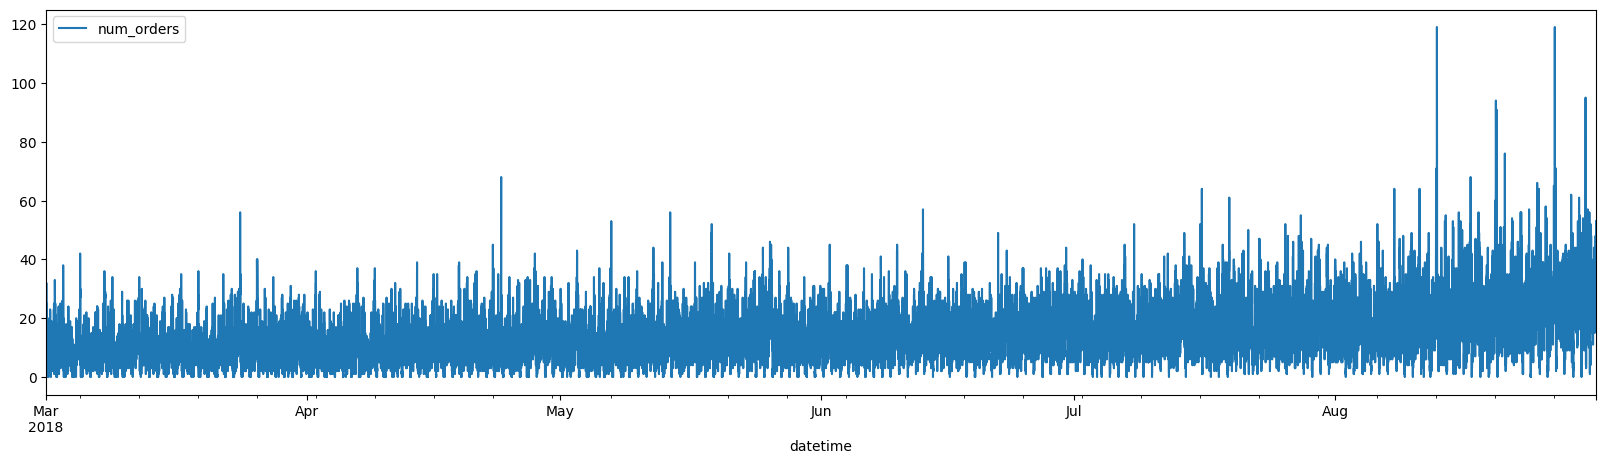

In [84]:
# Revisar el progreso de los datos
df.plot(figsize=(20,5))
plt.show()

Los datos tienen un desarrollo relativamente denso con intervalos de 10 minutos. Para alinearnos con los requisitos de predicción, vamos a remuestrear los datos de intervalos de 10 minutos a intervalos por hora, ya que nos interesa predecir el número de pedidos de taxi para la próxima hora.

Utilizando estos datos remuestreados, analizaremos los patrones de tendencia y estacionalidad.

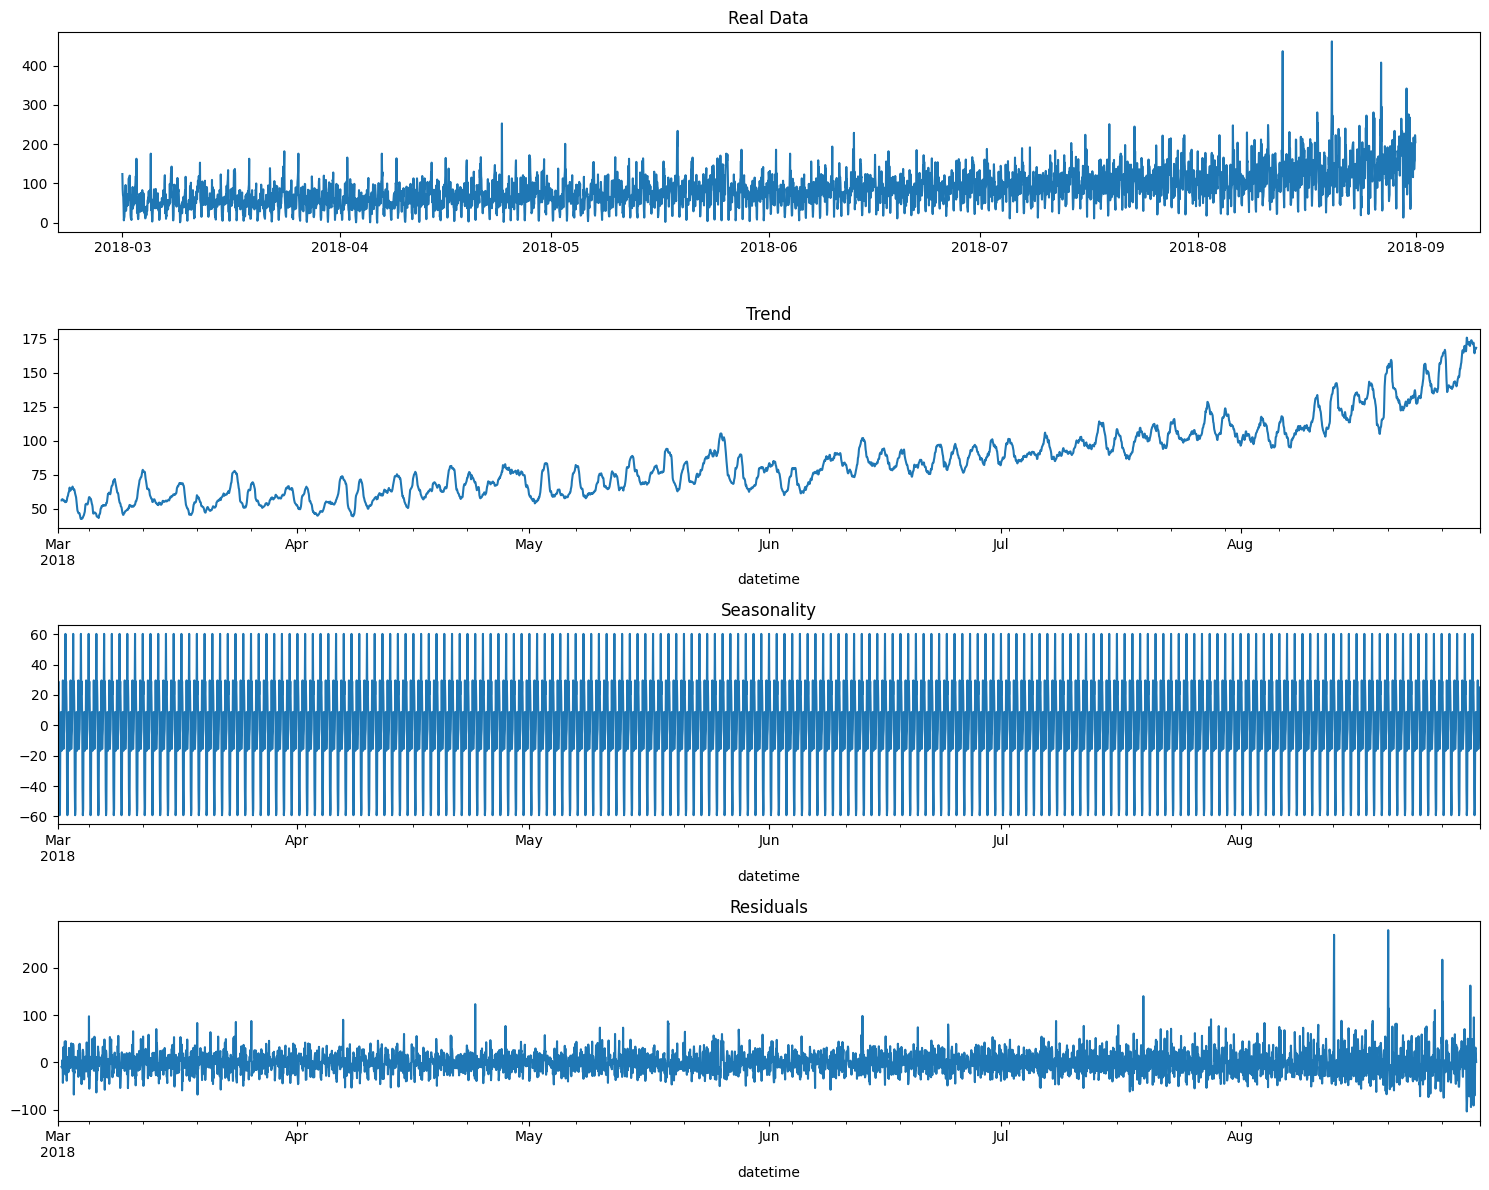

In [85]:
# Realizar remuestreos por hora y leer las tendencias y estacionalidades de los datos
data = df.resample('1H').sum()
decomposed = seasonal_decompose(data)

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(data)
plt.title('Real Data')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Los datos muestran una clara tendencia ascendente a lo largo del tiempo, especialmente en agosto, donde hay un aumento significativo en los pedidos. Sin embargo, los patrones de estacionalidad son difíciles de discernir con los datos horarios actuales. Para entender mejor la estacionalidad, remuestrearemos los datos a intervalos diarios.

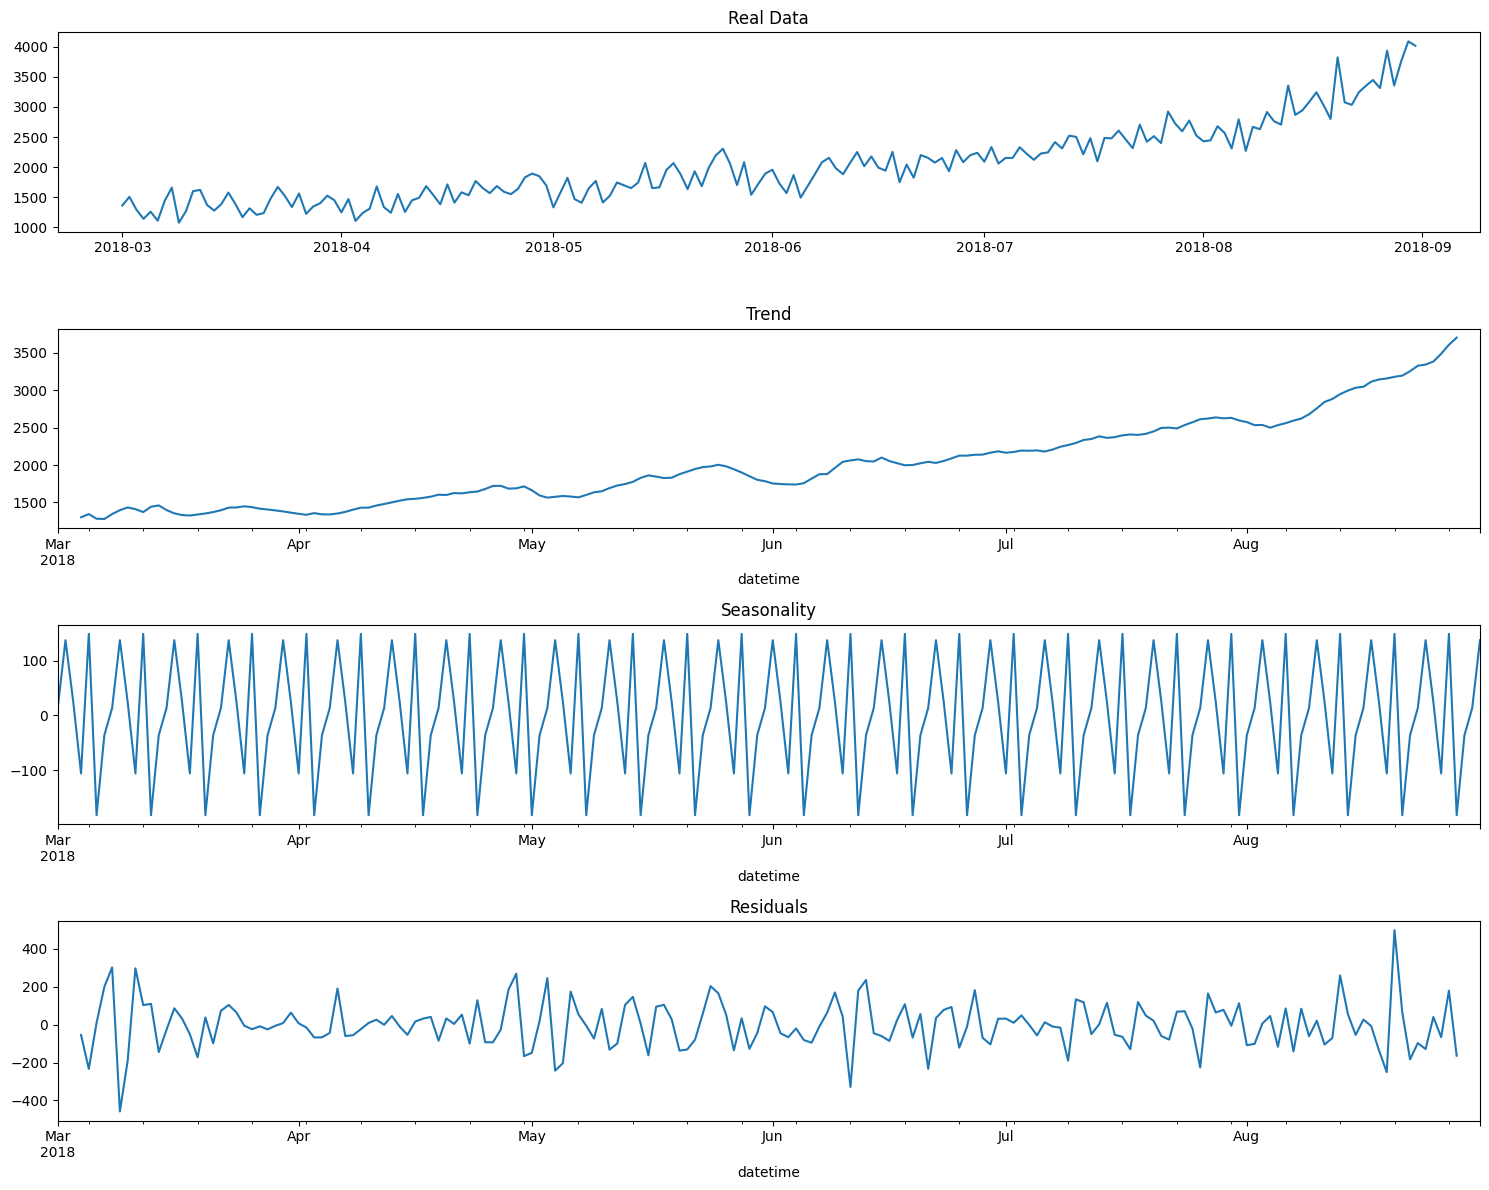

In [86]:
# Remuestrear por día y leer la tendencia y estacionalidad de los datos
data_daily = data.resample('1D').sum()
decomposed = seasonal_decompose(data_daily)

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(data_daily)
plt.title('Real Data')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

La tendencia ascendente se está volviendo más evidente y los patrones de estacionalidad también están comenzando a mostrarse. Calculemos el promedio móvil o la media móvil a partir de estos datos diarios.

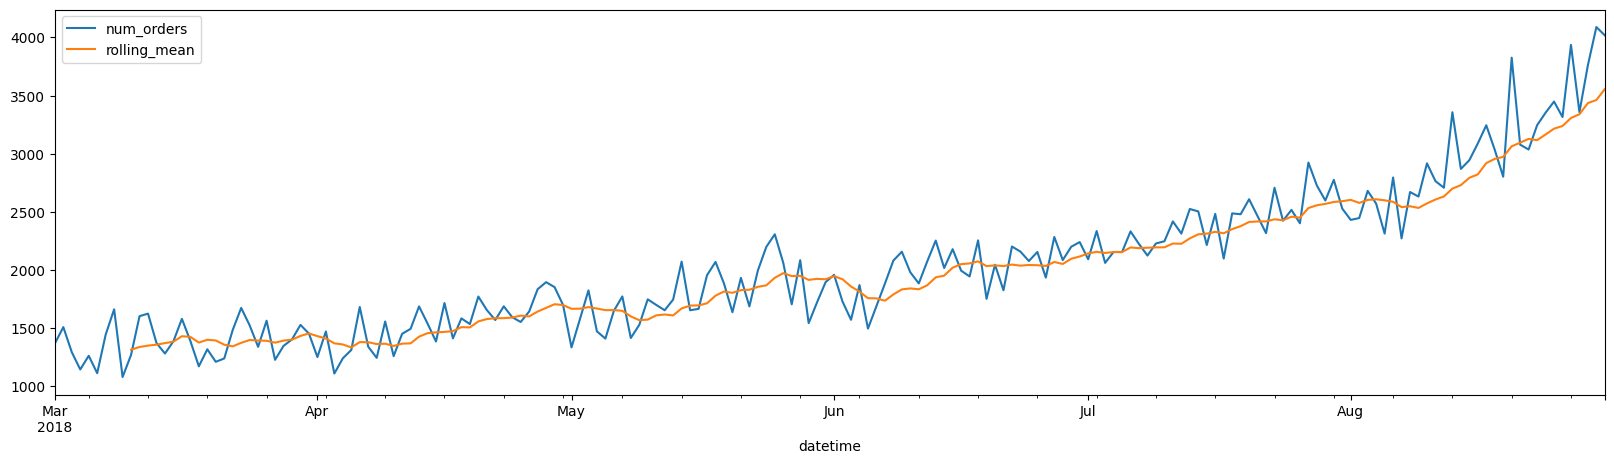

In [87]:
# Revisar los promedios móviles
data_daily['rolling_mean'] = data_daily.rolling(10).mean()
data_daily.plot(figsize=(20,5))
plt.show()

El promedio móvil calculado de los datos diarios confirma la tendencia ascendente en el número de pedidos de taxi, lo cual concuerda con la tendencia observada en el gráfico descompuesto. Además, indica que el número de pedidos de taxi tiende a ser mayor en agosto.

Realizaremos un análisis más detallado de los datos diarios por hora para agosto con el fin de investigar más a fondo las tendencias y los patrones de estacionalidad.

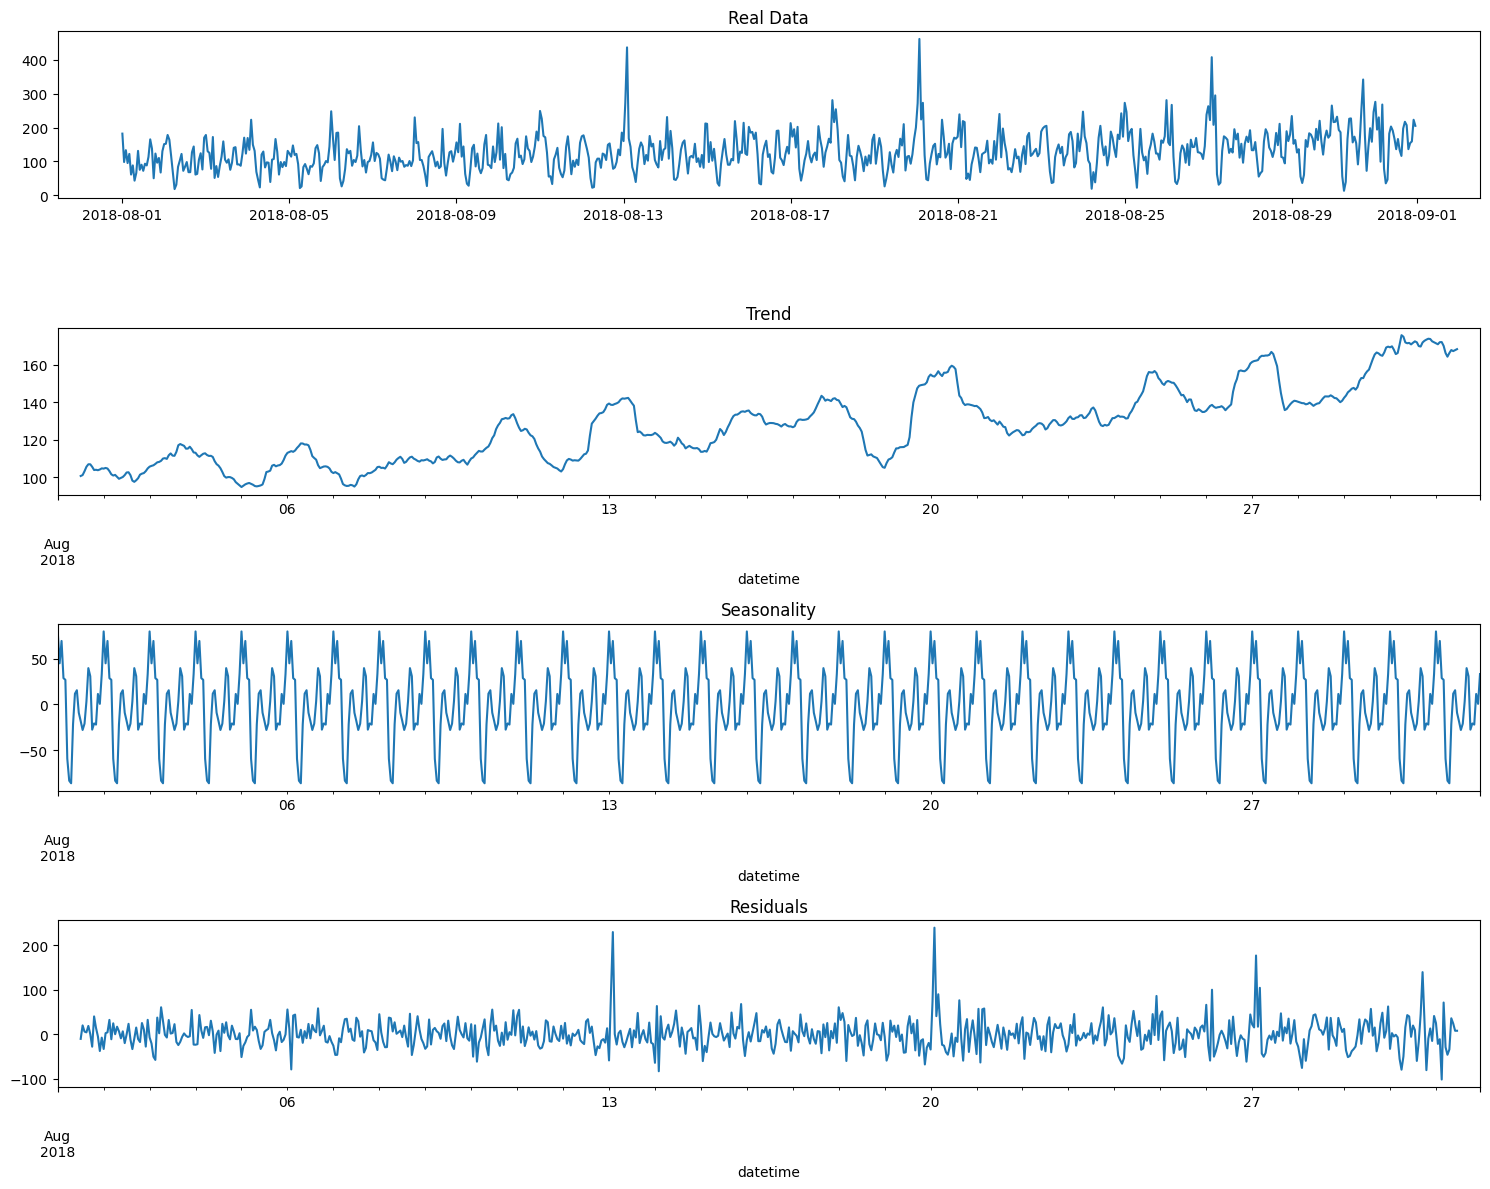

In [88]:
# Leer las tendencias y la estacionalidad para los datos de agosto de 2018
data_aug = data['2018-08-01':'2018-08-31']
decomposed = seasonal_decompose(data_aug)

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(data_aug)
plt.title('Real Data')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

Observamos una tendencia fluctuante en el número de pedidos, con un aumento gradual hacia el final del mes. El patrón de estacionalidad sigue siendo relativamente estrecho, pero parece repetirse diariamente.

A continuación, examinaremos los datos a nivel semanal y nos centraremos en la muestra de datos para la semana de lunes a domingo, del 13 al 19 de agosto de 2018.

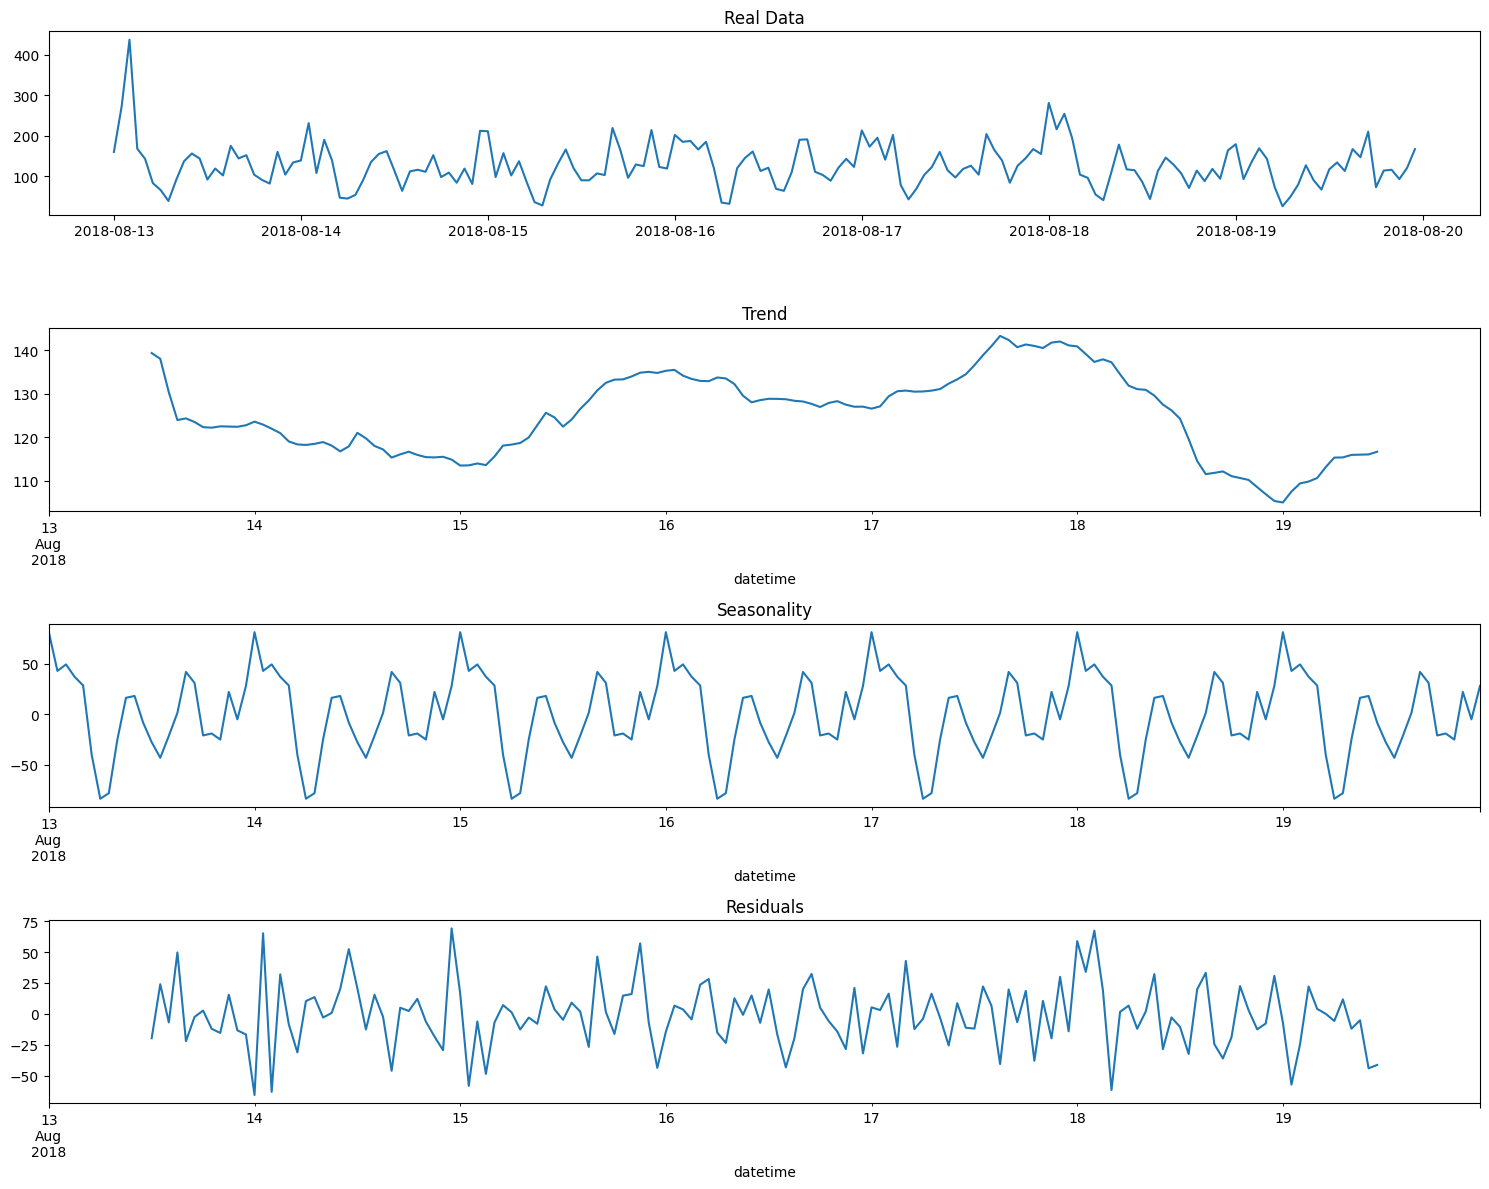

In [89]:
# Leer las tendencias y la estacionalidad semanal para los datos de agosto de 2018
data_aug_week = data['2018-08-13':'2018-08-19']
decomposed = seasonal_decompose(data_aug_week)

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(data_aug_week)
plt.title('Real Data')

plt.subplot(412)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(414)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

El número de pedidos alcanzó su punto máximo el sábado 18 de agosto de 2018. Sin embargo, hacia el domingo, el número de pedidos parece haber disminuido.

Dado que nuestra tarea es predecir datos horarios, vamos a examinar la tendencia del desarrollo de los datos horarios para un solo día. Nos centraremos en los datos del 7 de agosto de 2018 para observar el patrón diario.

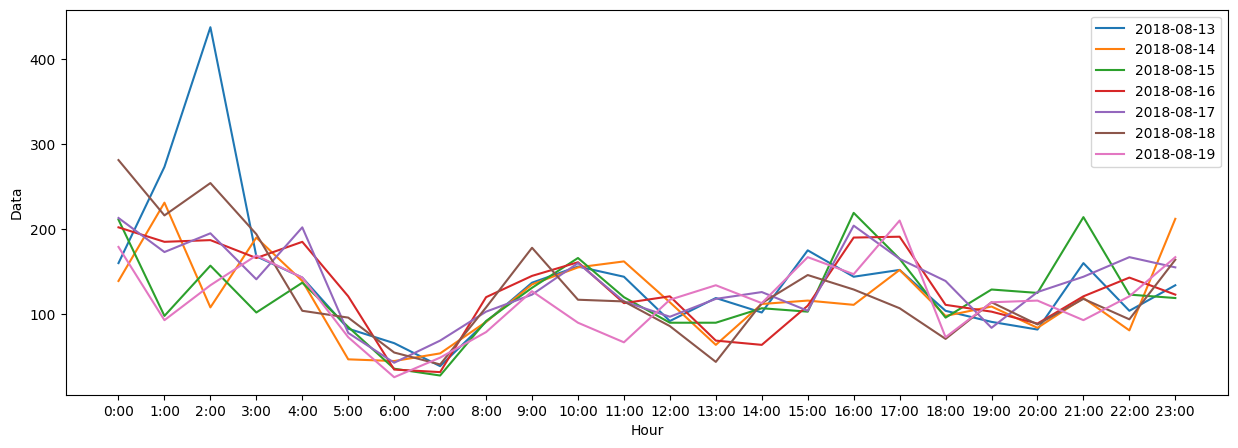

In [90]:
# Obtener datos para una semana
data_one_week = data.loc['2018-08-13':'2018-08-19']

# Recopilar datos por fecha y mostrarlos en un solo gráfico
fig, ax = plt.subplots(figsize=(15, 5))
labels = []
for day, day_data in data_one_week.groupby(data_one_week.index.date):
    # Recopilar datos por hora y calcular el promedio
    hourly_data = day_data.groupby(day_data.index.hour).mean()

    # Mostrar los datos en un solo gráfico con diferentes colores
    label = day.strftime('%Y-%m-%d')
    hourly_data.plot(ax=ax, label=label)
    labels.append(label)

# Configurar los valores y etiquetas en el eje x
ax.set_xticks(hourly_data.index)
ax.set_xticklabels([f'{hour}:00' for hour in hourly_data.index])

ax.set_xlabel('Hour')
ax.set_ylabel('Data')
ax.legend(labels=labels, loc='upper right')
plt.show()


Por lo regular, el nivel de demanda de taxis muestra una tendencia horaria similar todos los días de la semana. El primer pico ocurre alrededor de las 2 am, seguido de picos alrededor de las 10 am, 4 pm y 9 pm.

### 3.2 Análisis de Estacionalidad

A continuación, realizaremos un análisis de estacionalidad para determinar si los datos son estacionarios o no. Para comenzar, verificaremos la desviación estándar de nuestro conjunto de datos.

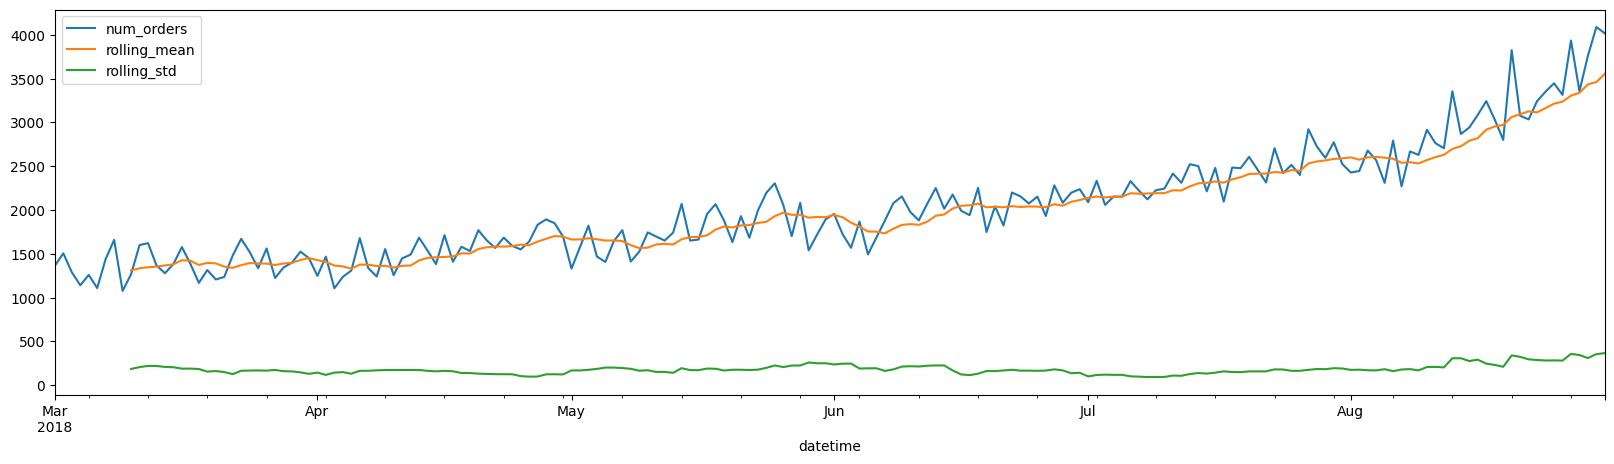

In [91]:
# Comprobar la desviación estándar
data_daily['rolling_std'] = data_daily['num_orders'].rolling(10).std()
data_daily.plot(figsize=(20,5))
plt.show()

Los datos de `rolling_std` parecen ser relativamente constantes, lo que indica que los datos podrían ser estacionarios en términos de varianza, a pesar de una tendencia creciente en el `rolling_mean`.

Para verificar esto, realizaremos pruebas estadísticas utilizando la Prueba de Dickey-Fuller Aumentada (ADF) y la Prueba Kwiatkowski-Phillips-Schmidt-Shin (KPSS) en el conjunto de datos original, `data`.

La hipótesis nula utilizada en estas pruebas es que la serie temporal tiene una raíz unitaria, lo que significa que los datos no son estacionarios. La hipótesis alternativa es que la serie temporal no tiene raíz unitaria y es estacionaria.

Una raíz unitaria en los datos de series temporales sugiere la presencia de algunos datos aleatorios o no estacionalidad. Los datos no estacionarios a menudo exhiben patrones de tendencia significativos o grandes fluctuaciones a lo largo del tiempo, lo que hace que sea desafiante predecir utilizando modelos tradicionales de series temporales.

In [92]:
# Comprobando la estacionalidad utilizando la Prueba de Dickey-Fuller Aumentada
def adf_test(series):
    result = sm.tsa.stattools.adfuller(series)
    print('ADF Statistic: {:.3f}'.format(result[0]))
    print('p-value: {:.3f}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.3f}'.format(key, value))
    if result[0] < result[4]['5%']:
        print('Reject null hypothesis; data is stationary')
    else:
        print('Fail to reject null hypothesis; data is non-stationary')

# Ejecutar la prueba
adf_test(data)

ADF Statistic: -3.069
p-value: 0.029
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Reject null hypothesis; data is stationary


In [93]:
# Comprobando la estacionalidad utilizando la Prueba Kwiatkowski-Phillips-Schmidt-Shin
def kpss_test(timeseries):
    result = kpss(timeseries)
    print('KPSS Test Statistic:', result[0])
    print('p-value:', result[1])
    print('Lags Used:', result[2])
    print('Critical Values:')
    for key, value in result[3].items():
        print(f'   {key}: {value}')
    alpha = 0.05
    if result[1] < alpha:
        print("P-value is less than alpha. Rejecting null hypothesis.")
        print("The time series is stationary.")
    else:
        print("P-value is greater than alpha. Failed to reject null hypothesis.")
        print("The time series is non-stationary.")

# Ejecutar la prueba        
kpss_test(data)

KPSS Test Statistic: 10.913353384602186
p-value: 0.01
Lags Used: 32
Critical Values:
   10%: 0.347
   5%: 0.463
   2.5%: 0.574
   1%: 0.739
P-value is less than alpha. Rejecting null hypothesis.
The time series is stationary.


Basado en los resultados de nuestras pruebas, estos datos parecen ser estacionarios. Como resultado, se pueden aplicar métodos analíticos tradicionales como ARIMA (Media Móvil Integrada Auto-Regresiva) a estos datos.

## 4 Entrenamiento y Pruebas

Los datos que tenemos son estacionarios, lo que nos permite analizarlos utilizando métodos tradicionales como ARIMA sin necesidad de ingeniería de características. Sin embargo, para obtener resultados óptimos, exploraremos tanto el análisis tradicional como los modelos de aprendizaje automático.

**Realizar la Puntuación**

In [94]:
# Define una función para calcular el error cuadrático medio (RMSE)
def rmse(y_actual, y_pred):
  return mean_squared_error(y_actual, y_pred, squared=False) 

rmse_scorer = make_scorer(rmse)

### 4.1 Modelo ARIMA

#### 4.1.1 Dividir (Split) los Datos

In [95]:
# Dividir los datos en entrenamiento y prueba
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

print(train.shape)
print(test.shape)

(3974, 1)
(442, 1)


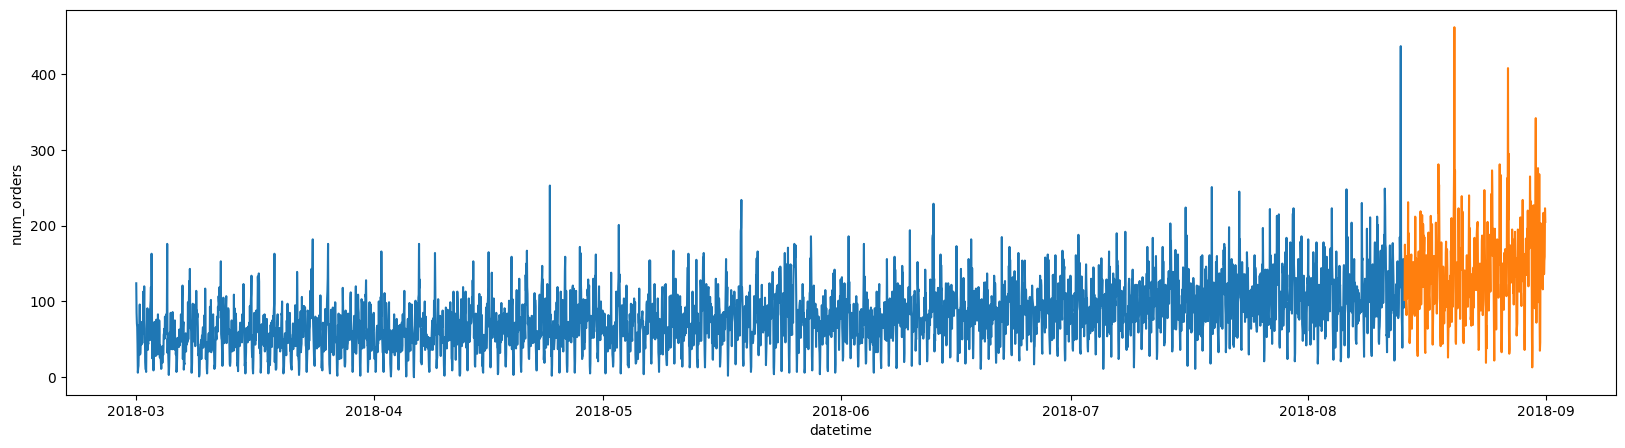

In [96]:
# Visualizar los datos después de la división
plt.figure(figsize=(20,5))
sns.lineplot(x=train.index, y=train['num_orders']);
sns.lineplot(x=test.index, y=test['num_orders']);

Los datos se han dividido correctamente según la solicitud de la tarea, con el 10% asignado al conjunto de prueba.

#### 4.1.2 Buscando los Mejores Valores de p, d y q con Auto ARIMA

In [97]:
# Implementar auto_arima
best_pdq = auto_arima(data, trace=True, suppress_warnings=True)
best_pdq.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=44886.781, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=44502.251, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=44355.432, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=44884.782, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.54 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=44353.436, Time=0.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=43750.780, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=inf, Time=0.66 sec
 ARIMA(1,1,3)(0,0,0)[0]             : AIC=inf, Time=0.84 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0]          
Total fit time: 9.09

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4416
Model:               SARIMAX(0, 1, 2)   Log Likelihood              -21872.390
Date:                Fri, 19 Jul 2024   AIC                          43750.780
Time:                        14:16:09   BIC                          43769.958
Sample:                    03-01-2018   HQIC                         43757.544
                         - 08-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6232      0.010    -60.181      0.000      -0.643      -0.603
ma.L2         -0.3606      0.010    -34.896      0.000      -0.381      -0.340
sigma2      1175.6524     15.473     75.983      0.000    1145.327    1205.978
===================================================================================
Ljung-Box (L1) (Q):                  29.37   Jarque-Bera (JB):              3323.38
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.36   Skew:                             0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Basado en los cálculos de auto_arima, los mejores parámetros para p-d-q son (0, 1, 2). Ahora aplicaremos estos parámetros al modelo ARIMA.

#### 4.1.3 Probar el Modelo ARIMA

In [98]:
%%time
# Crear el modelo
y = train

ARIMAmodel = ARIMA(y, order = (0, 1, 2))
ARIMAmodel = ARIMAmodel.fit()

CPU times: total: 391 ms
Wall time: 334 ms


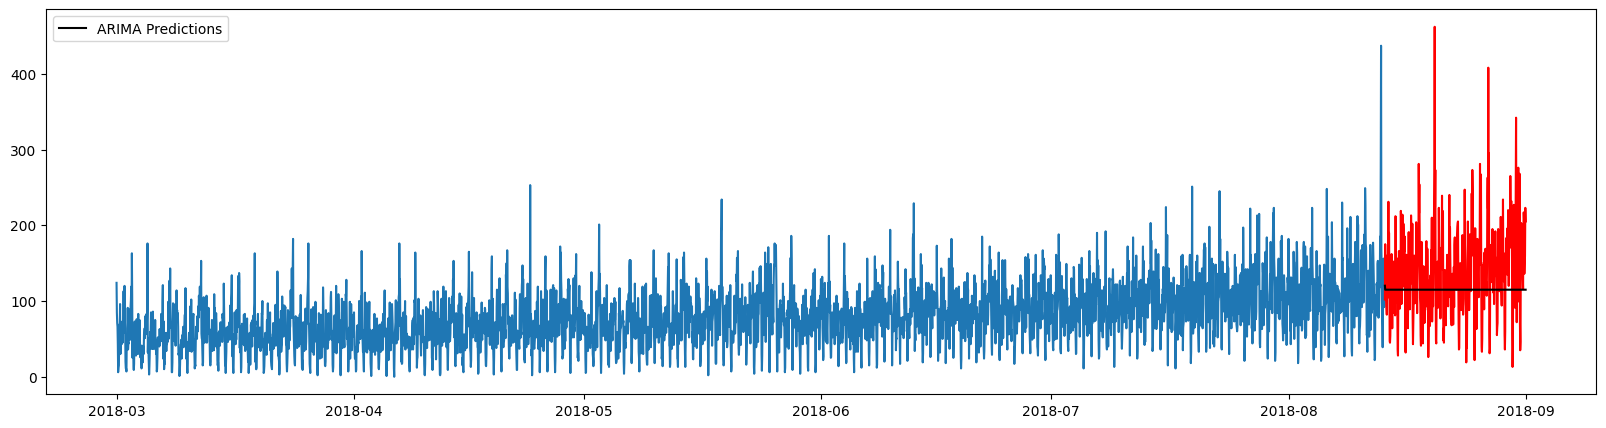

In [99]:
# Predicción
y_pred = ARIMAmodel.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['predictions'] 

plt.figure(figsize=(20,5))
plt.plot(train['num_orders'])
plt.plot(test['num_orders'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()

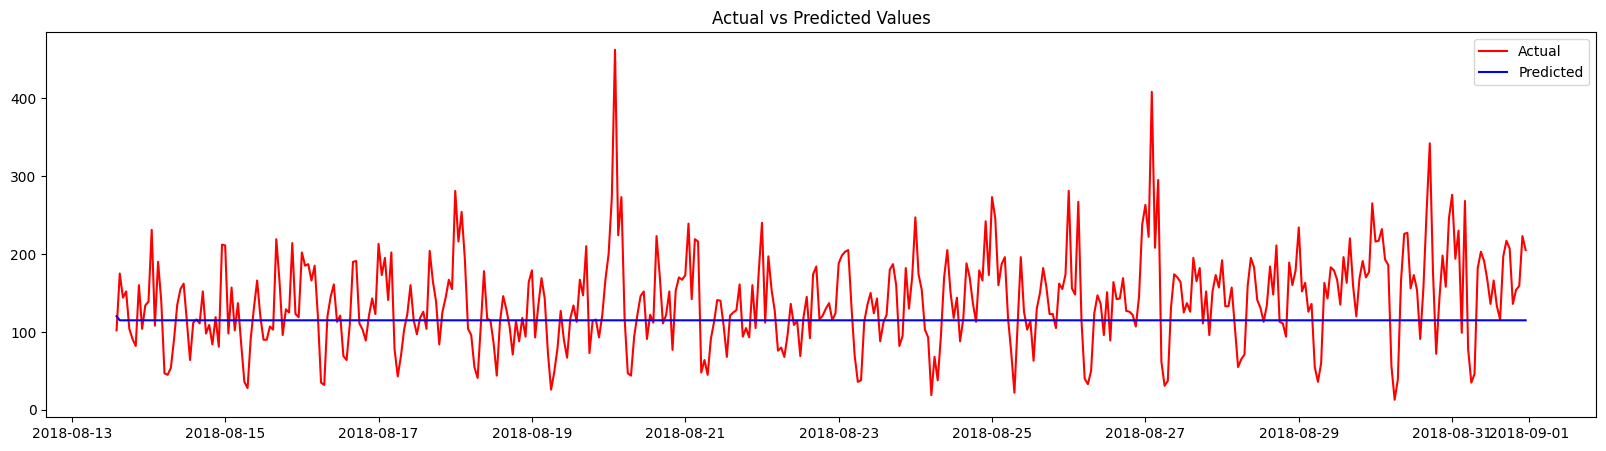

In [100]:
# Gráfico de Valores Reales vs Predicciones
plt.figure(figsize=(20, 5))
plt.plot(test['num_orders'], color='red', label='Actual')
plt.plot(y_pred_out, color='blue', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

In [101]:
# Calcular el valor RMSE
skor_ARIMA = rmse(test, y_pred_out)
skor_ARIMA

63.51176613960698

Este modelo parece estar teniendo un rendimiento deficiente. Las predicciones muestran consistentemente el mismo número, resultando en una puntuación de error extremadamente alta, muy por encima del límite de tolerancia establecido para este proyecto, que es 48. Parece que no podemos depender de las recomendaciones de auto_arima. Por lo tanto, intentaremos varias combinaciones de p-d-q y presentaremos los mejores resultados aquí.


In [102]:
%%time
# Crear un nuevo modelo ARIMA con una selección aleatoria de p-d-q
y = train

ARIMAmodel_2 = ARIMA(y, order = (24, 2, 30))
ARIMAmodel_2 = ARIMAmodel_2.fit()

CPU times: total: 1min 37s
Wall time: 1min 50s


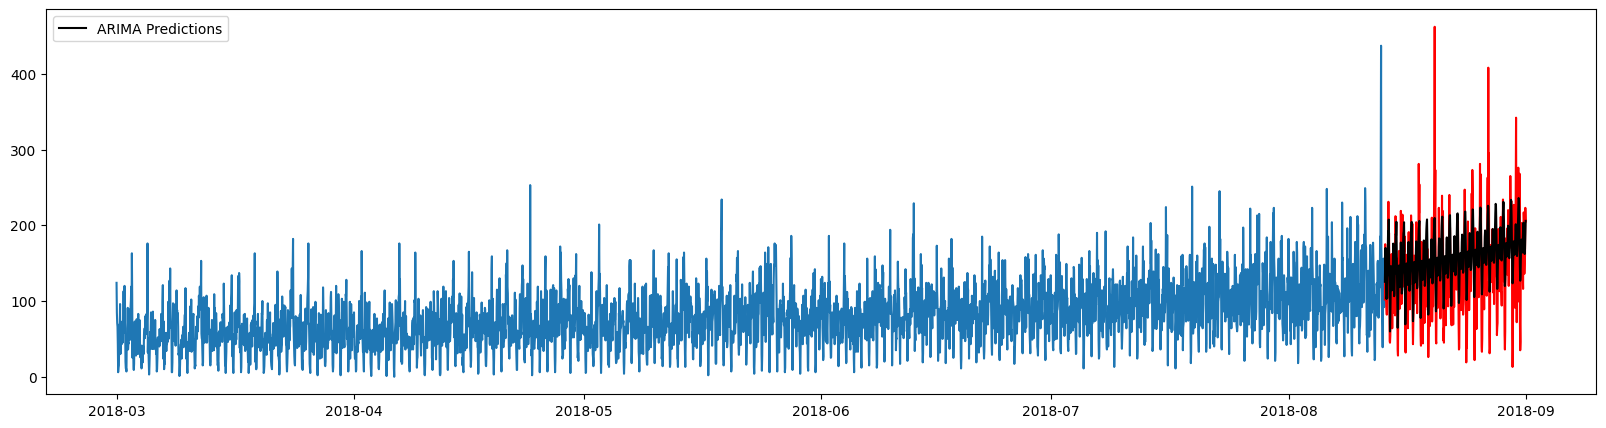

In [103]:
# Predicción
y_pred = ARIMAmodel_2.get_forecast(len(test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel_2.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df['predictions'] 

plt.figure(figsize=(20,5))
plt.plot(train['num_orders'])
plt.plot(test['num_orders'], color='red')
plt.plot(y_pred_out, color='black', label = 'ARIMA Predictions')
plt.legend()

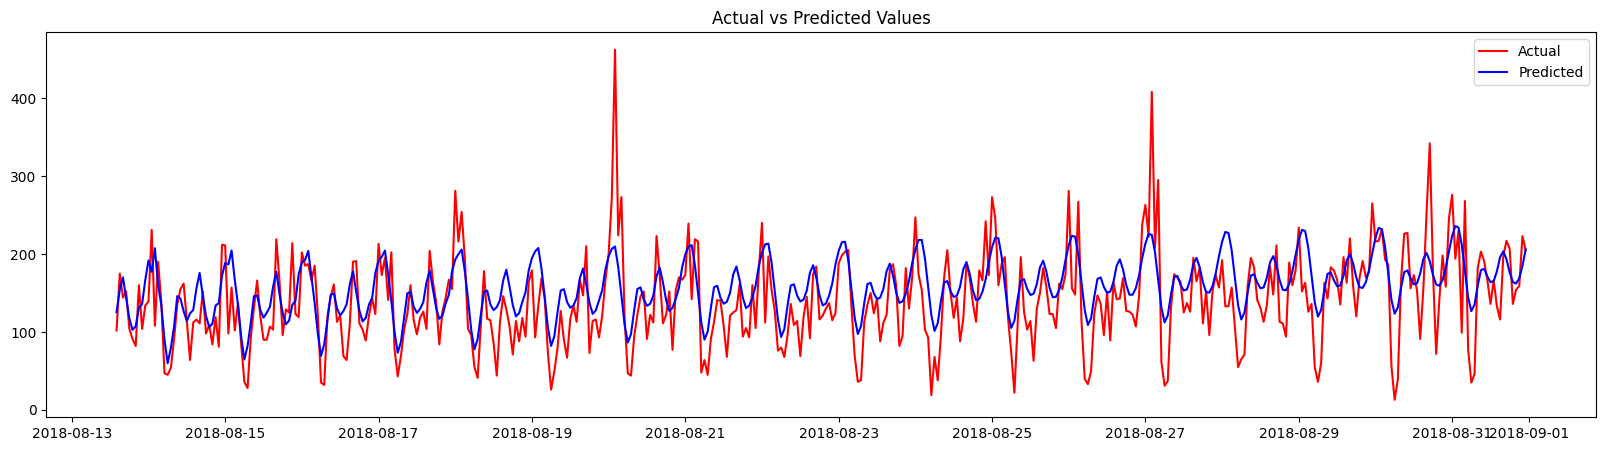

In [104]:
# Gráfico de Valores Reales vs Predicciones
plt.figure(figsize=(20, 5))
plt.plot(test['num_orders'], color='red', label='Actual')
plt.plot(y_pred_out, color='blue', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

In [105]:
# Calcular la puntuación RMSE
skor_ARIMA = rmse(test, y_pred_out)
skor_ARIMA

45.75420536822434

Experimentamos con varias combinaciones de p-d-q, y la combinación más prometedora que encontramos fue (24, 2, 30). Como resultado, la puntuación del RMSE se redujo exitosamente a menos de 48.

### 4.2 Modelo Prophet 

Para usar el modelo Prophet, necesitamos preparar un conjunto de datos específico con una estructura de datos estándar que contenga dos columnas: `ds` para la fecha y `y` para los valores.

In [106]:
# Crea un nuevo DataFrame con un índice numérico y columnas 'ds' y 'y'
new_df = pd.DataFrame({
    'ds': data.index,
    'y': data['num_orders']
}).reset_index(drop=True)

print('Dataset size is', new_df.shape)
new_df.head()

Dataset size is (4416, 2)


ds    y
0 2018-03-01 00:00:00  124
1 2018-03-01 01:00:00   85
2 2018-03-01 02:00:00   71
3 2018-03-01 03:00:00   66
4 2018-03-01 04:00:00   43

In [107]:
# Dividir los datos en entrenamiento y prueba
train_new, test_new = train_test_split(new_df, shuffle=False, test_size=0.1)
train = train.dropna()

print(train_new.shape)
print(test_new.shape)

(3974, 2)
(442, 2)


#### 4.2.1 Implementando el Algoritmo de Prophet

In [108]:
# Aplicar el algoritmo Prophet a los datos
m = Prophet()
m.fit(train_new)

14:18:01 - cmdstanpy - INFO - Chain [1] start processing
14:18:01 - cmdstanpy - INFO - Chain [1] done processing


In [109]:
# Crear un DataFrame para predecir las siguientes 442 filas, de acuerdo con el número de conjuntos de datos de prueba
future = m.make_future_dataframe(periods=442, freq='H')

# Predicción de datos
forecast = m.predict(future)

In [110]:
# Comprobar los resultados
forecast

ds     trend  yhat_lower  yhat_upper  trend_lower  \
0    2018-03-01 00:00:00  54.62150    57.48718   118.41602     54.62150   
1    2018-03-01 01:00:00  54.62736    58.23209   121.30599     54.62736   
2    2018-03-01 02:00:00  54.63321    53.99164   115.74818     54.63321   
3    2018-03-01 03:00:00  54.63907    39.13142   102.22753     54.63907   
4    2018-03-01 04:00:00  54.64492    11.58084    76.14114     54.64492   
...                  ...       ...         ...         ...          ...   
4411 2018-08-31 19:00:00 125.59915    95.94291   157.72929    125.10057   
4412 2018-08-31 20:00:00 125.62280    98.37399   164.85726    125.12207   
4413 2018-08-31 21:00:00 125.64645   115.76032   178.42097    125.14357   
4414 2018-08-31 22:00:00 125.67010   127.21777   189.86020    125.16531   
4415 2018-08-31 23:00:00 125.69375   135.61034   197.62034    125.18693   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
0        54.62150        34.11172              34.11172              34.11172   
1        54.62736        34.19484              34.19484              34.19484   
2        54.63321        30.31583              30.31583              30.31583   
3        54.63907        16.23714              16.23714              16.23714   
4        54.64492        -9.60932              -9.60932              -9.60932   
...           ...             ...                   ...                   ...   
4411    126.11247        -0.00358              -0.00358              -0.00358   
4412    126.13819         7.09103               7.09103               7.09103   
4413    126.16390        21.96209              21.96209              21.96209   
4414    126.18705        34.92001              34.92001              34.92001   
4415    126.20817        41.16214              41.16214              41.16214   

         daily  daily_lower  daily_upper   weekly  weekly_lower  weekly_upper  \
0     32.10460     32.10460     32.10460  2.00712       2.00712       2.00712   
1     32.69179     32.69179     32.69179  1.50305       1.50305       1.50305   
2     29.34253     29.34253     29.34253  0.97331       0.97331       0.97331   
3     15.80939     15.80939     15.80939  0.42775       0.42775       0.42775   
4     -9.48573     -9.48573     -9.48573 -0.12359      -0.12359      -0.12359   
...        ...          ...          ...      ...           ...           ...   
4411 -11.90799    -11.90799    -11.90799 11.90441      11.90441      11.90441   
4412  -4.78844     -4.78844     -4.78844 11.87947      11.87947      11.87947   
4413  10.21550     10.21550     10.21550 11.74659      11.74659      11.74659   
4414  23.41414     23.41414     23.41414 11.50587      11.50587      11.50587   
4415  30.00342     30.00342     30.00342 11.15872      11.15872      11.15872   

      multiplicative_terms  multiplicative_terms_lower  \
0                  0.00000                     0.00000   
1                  0.00000                     0.00000   
2                  0.00000                     0.00000   
3                  0.00000                     0.00000   
4                  0.00000                     0.00000   
...                    ...                         ...   
4411               0.00000                     0.00000   
4412               0.00000                     0.00000   
4413               0.00000                     0.00000   
4414               0.00000                     0.00000   
4415               0.00000                     0.00000   

      multiplicative_terms_upper      yhat  
0                        0.00000  88.73322  
1                        0.00000  88.82219  
2                        0.00000  84.94905  
3                        0.00000  70.87621  
4                        0.00000  45.03560  
...                          ...       ...  
4411                     0.00000 125.59557  
4412                     0.00000 132.71384  
4413                     0.00000 147.60855  
4414                     0.0

Después de realizar la predicción utilizando el algoritmo Prophet, obtenemos un nuevo conjunto de datos que contiene 4416 filas, coincidiendo con el número de filas en el conjunto de datos inicial.

In [111]:
# Mostrar gráficos de los valores reales y las predicciones de los modelos
plot_plotly(m, forecast)

Los puntos negros son los valores reales, mientras que las líneas azules son las predicciones del modelo.

In [112]:
# Mostrar las tendencias generales, semanales y diarias de los datos
plot_components_plotly(m, forecast)

In [113]:
# Recuperar los datos predictivos para compararlos con el conjunto de datos de prueba
predictions = forecast.iloc[-442:]['yhat']

In [114]:
# Calcular el valor de RMSE
skor_prophet = rmse(test_new['y'], predictions)
skor_prophet

48.24348521749808

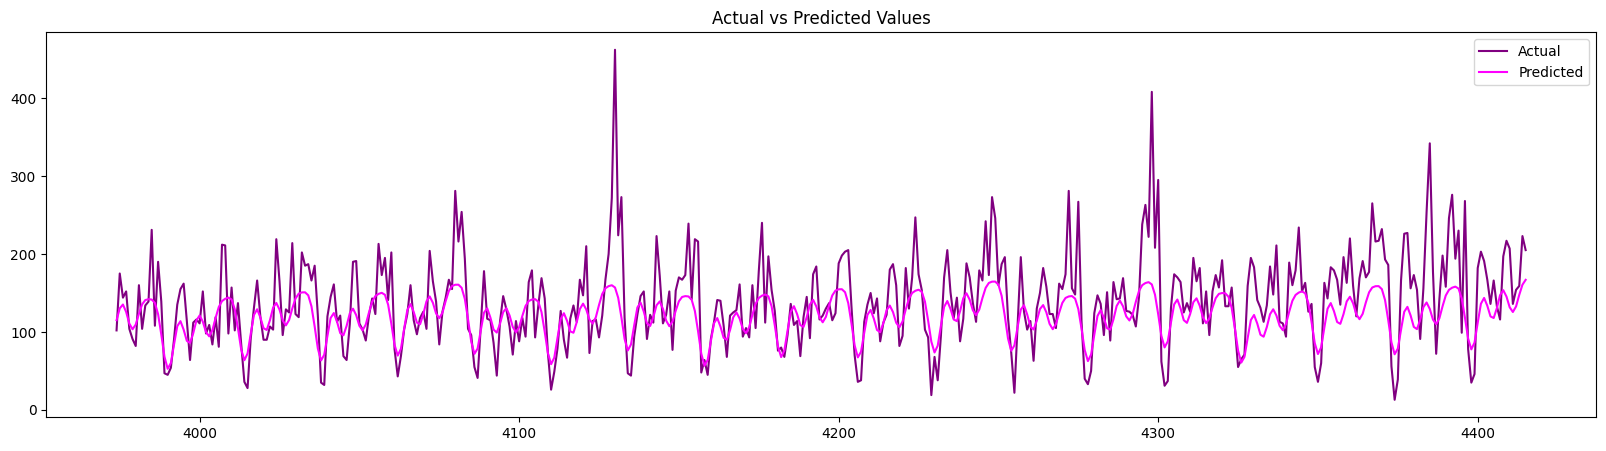

In [115]:
# Gráfico de Valores Reales vs Predicciones
predict = pd.DataFrame(predictions).set_index(test_new.index)

plt.figure(figsize=(20, 5))
plt.plot(test_new['y'], color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

La puntuación de RMSE obtenida está ligeramente por encima del límite máximo requerido por esta tarea, que es 48. Por lo tanto, exploraremos otro modelo para mejorar las predicciones.

### 4.3 Preparar los Datos para Modelos de Aprendizaje Automático

Ahora vamos a pasar al enfoque de aprendizaje automático. Para utilizar adecuadamente el modelo de aprendizaje automático, necesitamos diseñar un nuevo conjunto de datos con características adicionales extraídas de las características principales existentes, es decir, `datetime` y `num_orders`.

#### 4.3.1 Crear de Nuevas Características

In [116]:
# Crear nuevas características de 'datetime index'
data_new = data.copy()

data_new['year'] = data_new.index.year 
data_new['month'] = data_new.index.month 
data_new['day'] = data_new.index.day
data_new['dayofweek_num'] = data_new.index.dayofweek  
data_new['quarter'] = data_new.index.quarter 

data_new.head()

num_orders  year  month  day  dayofweek_num  quarter
datetime                                                                 
2018-03-01 00:00:00         124  2018      3    1              3        1
2018-03-01 01:00:00          85  2018      3    1              3        1
2018-03-01 02:00:00          71  2018      3    1              3        1
2018-03-01 03:00:00          66  2018      3    1              3        1
2018-03-01 04:00:00          43  2018      3    1              3        1

In [117]:
# Crear una nueva característica a partir de 'num_orders'
# Crear retrasos (lags) de hasta 6 horas
lags = [1, 2, 3, 4, 5, 6]
for lag in lags:
    data_new[f'lag_{lag}'] = data_new['num_orders'].shift(lag)

# Crear una media móvil con una ventana de 3 a 5 horas
windows = [3, 4, 5]
for window in windows:
    data_new[f'rolling_mean_{window}'] = data_new['num_orders'].rolling(window=window, min_periods=1).mean()

# Crear una suma móvil con una ventana de 3 a 5 horas
for window in windows:
    data_new[f'rolling_sum_{window}'] = data_new['num_orders'].rolling(window=window, min_periods=1).sum()

# Crear una media acumulativa (expanding mean) 
data_new['expanding_mean'] = data_new['num_orders'].expanding(1).mean()

# Eliminar filas con valores NaN
data_new = data_new.dropna()

display(data_new.head())
print('The size of the new dataset is', data_new.shape)

num_orders  year  month  day  dayofweek_num  quarter  \
datetime                                                                    
2018-03-01 06:00:00          12  2018      3    1              3        1   
2018-03-01 07:00:00          15  2018      3    1              3        1   
2018-03-01 08:00:00          34  2018      3    1              3        1   
2018-03-01 09:00:00          69  2018      3    1              3        1   
2018-03-01 10:00:00          64  2018      3    1              3        1   

                       lag_1    lag_2    lag_3    lag_4    lag_5     lag_6  \
datetime                                                                     
2018-03-01 06:00:00  6.00000 43.00000 66.00000 71.00000 85.00000 124.00000   
2018-03-01 07:00:00 12.00000  6.00000 43.00000 66.00000 71.00000  85.00000   
2018-03-01 08:00:00 15.00000 12.00000  6.00000 43.00000 66.00000  71.00000   
2018-03-01 09:00:00 34.00000 15.00000 12.00000  6.00000 43.00000  66.00000   
2018-03-01 10:00:00 69.00000 34.00000 15.00000 12.00000  6.00000  43.00000   

                     rolling_mean_3  rolling_mean_4  rolling_mean_5  \
datetime                                                              
2018-03-01 06:00:00        20.33333        31.75000        39.60000   
2018-03-01 07:00:00        11.00000        19.00000        28.40000   
2018-03-01 08:00:00        20.33333        16.75000        22.00000   
2018-03-01 09:00:00        39.33333        32.50000        27.20000   
2018-03-01 10:00:00        55.66667        45.50000        38.80000   

                     rolling_sum_3  rolling_sum_4  rolling_sum_5  \
datetime                                                           
2018-03-01 06:00:00       61.00000      127.00000      198.00000   
2018-03-01 07:00:00       33.00000       76.00000      142.00000   
2018-03-01 08:00:00       61.00000       67.00000      110.00000   
2018-03-01 09:00:00      118.00000      130.00000      136.00000   
2018-03-01 10:00:00      167.00000      182.00000      194.00000   

                     expanding_mean  
datetime                             
2018-03-01 06:00:00        58.14286  
2018-03-01 07:00:00        52.75000  
2018-03-01 08:00:00        50.66667  
2018-03-01 09:00:00        52.50000  
2018-03-01 10:00:00        53.54545

The size of the new dataset is (4410, 19)


#### 4.3.2 Preparar los Conjuntos de Datos de Entrenamiento y Prueba

In [118]:
# Dividir el conjunto de datos en entrenamiento y prueba
features = data_new.drop('num_orders', axis=1)
target = data_new['num_orders']

features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1,
                                                                 random_state=2023)

In [119]:
# Comprobar el tamaño del dataset
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(3969, 18)
(441, 18)
(3969,)
(441,)


### 4.4 Definir Funciones para Modelos de Aprendizaje Automático

#### 4.4.1 Entrenamiento del Modelo Sin Ajuste de Hiperparámetros

In [120]:
# Función entrenamiento del modelo sin ajuste
def train_model_no_tuning(model, features, target):
    scores = cross_val_score(model, features, target, scoring=rmse_scorer, cv=5).mean()

    return scores

#### 4.4.2 Entrenamiento del Modelo Con Ajuste de Hiperparámetros

In [121]:
# Función entrenamiento del modelo con ajuste
def train_model_tuning(model, features, target, param_distributions):
    # Crear un valor utilizando la función RMSE
    scorer = make_scorer(rmse, greater_is_better=False)

    # Definir un objeto RandomizedSearchCV
    random_search = RandomizedSearchCV(
        model, param_distributions=param_distributions,
        scoring=scorer, n_iter=10, cv=5, n_jobs=-1, random_state=2023
    )

    random_search.fit(features, target)
    
    # Imprimir los mejores parámetros y el RMSE
    print("Best Estimator:", random_search.best_estimator_)
    print("Best Parameters:", random_search.best_params_)
    print("Best RMSE:", -1 * random_search.best_score_)

### 4.5 Regresión Lineal

La regresión lineal es nuestro modelo base.

In [122]:
%%time

# Entrenar el modelo de regresión lineal sin ajuste de hiperparámetros
train_model_no_tuning(LinearRegression(), features_train, target_train)

CPU times: total: 93.8 ms
Wall time: 63.9 ms


6.244036299178344e-14

In [123]:
%%time

# Entrenar el modelo de regresión lineal con ajuste de hiperparámetros
param_distributions = {
    'fit_intercept': [True, False],
    'copy_X': [True, False]
}
train_model_tuning(LinearRegression(), features_train, target_train, param_distributions)

Best Estimator: LinearRegression()
Best Parameters: {'fit_intercept': True, 'copy_X': True}
Best RMSE: 6.245072985601402e-14
CPU times: total: 15.6 ms
Wall time: 2.31 s


Obtuvimos puntuaciones de error excepcionalmente bajas, casi cercanas a 0, con puntuaciones aún mejores en el modelo ajustado. Sin embargo, una puntuación tan notable puede generar preocupaciones sobre el sobreajuste. No obstante, hasta este punto, no hemos identificado errores en este código. Ahora, evaluaremos el modelo en el conjunto de datos de prueba.

In [124]:
%%time

# Evaluación en el conjunto de datos de prueba
LR = LinearRegression(fit_intercept=True, copy_X=True).fit(features_train, target_train)
LR_pred = LR.predict(features_test)
LR_rmse = rmse(target_test, LR_pred)
LR_rmse

CPU times: total: 0 ns
Wall time: 4.37 ms


1.800171973186188e-13

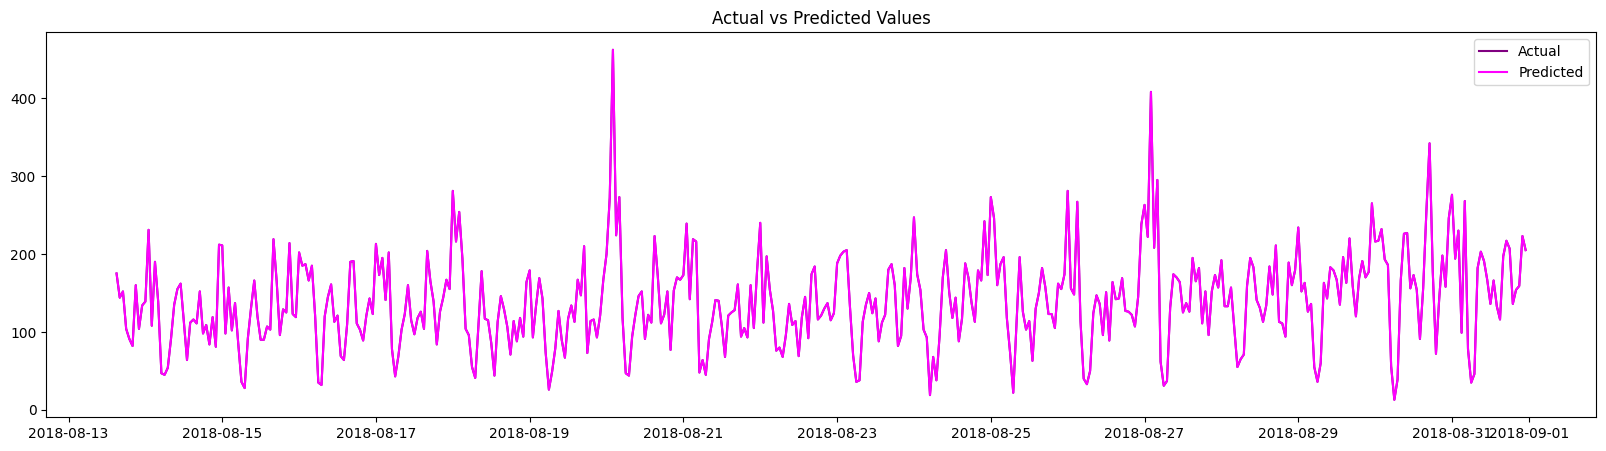

In [125]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(LR_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

La puntuación en los resultados de la prueba es tan baja como en los resultados de entrenamiento, y el gráfico también se alinea perfectamente, lo que indica que los resultados predichos coinciden estrechamente con los valores reales. Esto sugiere que el modelo funciona bien, aunque pueda parecer demasiado bueno para ser verdad.

### 4.6 Árbol de Decisión

In [126]:
%%time

# Entrenar el modelo de Regresión de Árbol de Decisión sin ajuste de hiperparámetros
train_model_no_tuning(DecisionTreeRegressor(random_state=2023), features_train, target_train)

CPU times: total: 93.8 ms
Wall time: 175 ms


15.762875240773582

El modelo funciona bastante bien; el valor de RMSE está muy por debajo del umbral de 48. Intentaremos ajustar los hiperparámetros.

In [127]:
%%time

# Entrenar el modelo de Regresión de Árbol de Decisión con ajuste de hiperparámetros
param_distributions = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'splitter': ['best', 'random'],
    'random_state': [2023] 
}

train_model_tuning(DecisionTreeRegressor(), features_train, target_train, param_distributions)

Best Estimator: DecisionTreeRegressor(max_depth=20, min_samples_leaf=4, min_samples_split=5,
                      random_state=2023)
Best Parameters: {'splitter': 'best', 'random_state': 2023, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': None, 'max_depth': 20}
Best RMSE: 14.926676674659792
CPU times: total: 0 ns
Wall time: 183 ms


El rendimiento mejora después del ajuste de hiperparámetros. Ahora, procederemos a probarlo en el conjunto de datos de prueba.

In [128]:
%%time

# Probar en el conjunto de datos de prueba
DT = DecisionTreeRegressor(splitter='best', random_state=2023, min_samples_split=5, 
                           min_samples_leaf=4, max_features=None, max_depth=20).fit(features_train, target_train)
DT_pred = DT.predict(features_test)
DT_rmse = rmse(target_test, DT_pred)
DT_rmse

CPU times: total: 31.2 ms
Wall time: 32.5 ms


37.52692492142184

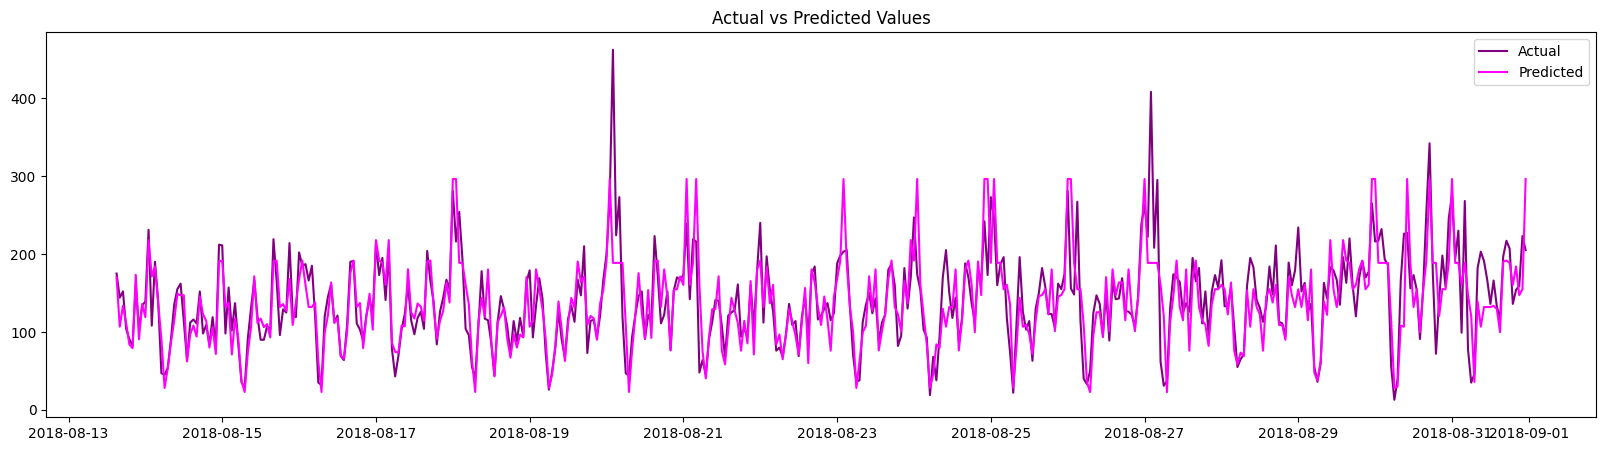

In [129]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(DT_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

La puntuación es significativamente más alta que la puntuación de validación observada durante el entrenamiento, aunque aún se mantiene por debajo del umbral de 48.

### 4.7 Bosque Aleatorio

In [130]:
%%time

# Entrenar el modelo de Bosque Aleatorio sin ajuste de hiperparámetros
train_model_no_tuning(RandomForestRegressor(random_state=2023), features_train, target_train)

CPU times: total: 7.48 s
Wall time: 9.96 s


9.986458141043636

Obtuvimos una puntuación bastante buena, superando la del modelo de Árbol de Decisión. A continuación, intentaremos usar el ajuste de hiperparámetros.

In [131]:
%%time

# Entrenar el modelo de Bosque Aleatorio con ajuste de hiperparámetros
param_distributions = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False],
    'random_state': [2023] # Número específico para controlar la aleatoriedad
}

train_model_tuning(RandomForestRegressor(), features_train, target_train, param_distributions)

Best Estimator: RandomForestRegressor(bootstrap=False, max_features=None, min_samples_split=10,
                      n_estimators=200, random_state=2023)
Best Parameters: {'random_state': 2023, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': None, 'bootstrap': False}
Best RMSE: 15.12067942428636
CPU times: total: 4.58 s
Wall time: 12.8 s


La puntuación de error es, de hecho, más alta después del ajuste de hiperparámetros. Por lo tanto, realizaremos la prueba sin ajuste de hiperparámetros.

In [132]:
%%time

# Evaluación en el conjunto de datos de prueba
RFR = RandomForestRegressor().fit(features_train, target_train)
RFR_pred = RFR.predict(features_test)
RFR_rmse = rmse(target_test, RFR_pred)
RFR_rmse

CPU times: total: 2 s
Wall time: 2.55 s


30.27959601647015

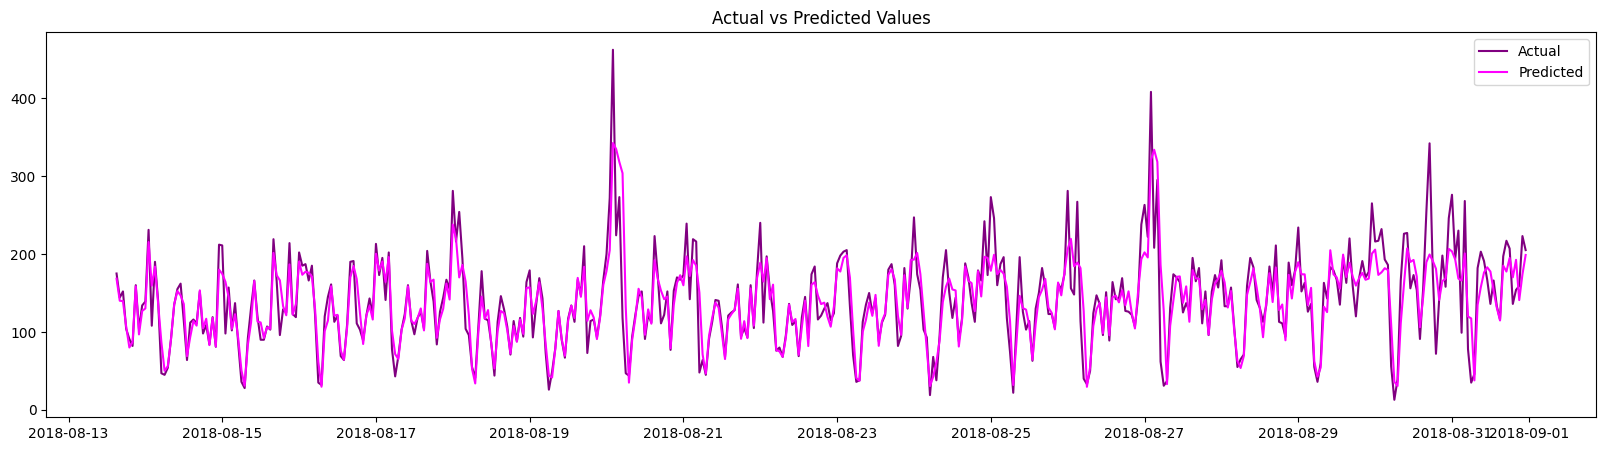

In [133]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(RFR_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

Obtuvimos mejores resultados en comparación con el Árbol de Decisión.

### 4.8 XGBoost Regressor

In [134]:
%%time

# Entrenar el modelo de Regresor XGBoost sin ajuste de hiperparámetros
train_model_no_tuning(XGBRegressor(), features_train, target_train)

CPU times: total: 5.98 s
Wall time: 503 ms


8.819543443604658

Las puntuaciones están mejorando.

In [135]:
%%time

# Entrenamiento con ajuste de hiperparámetros
param_distributions = {
    'max_depth'    : sp_randInt(5, 10),
    'n_estimators' : sp_randInt(50, 100),
    'learning_rate': sp_randFloat(),
    'subsample'    : sp_randFloat()
}

train_model_tuning(XGBRegressor(), features_train, target_train, param_distributions)

Best Estimator: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.10395183635292826,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=97, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)
Best Parameters: {'learning_rate': 0.10395183635292826, 'max_depth': 5, 'n_estimators': 97, 'subsample': 0.19586383749144975}
Best RMSE: 8.441529320409353
CPU times: total: 2 s
Wall time: 3.42 s


Las puntuaciones son aún mejores. Procederemos a probar en el conjunto de datos de prueba.

In [136]:
%%time

# Evaluación en el conjunto de datos de prueba
XGBR = XGBRegressor(learning_rate=0.09702613049463282, max_depth=8, 
                    n_estimators=73, subsample=0.566905715389558).fit(features_train, target_train)
XGBR_pred = XGBR.predict(features_test)
XGBR_rmse = rmse(target_test, XGBR_pred)
XGBR_rmse

CPU times: total: 2.17 s
Wall time: 173 ms


31.521429303189187

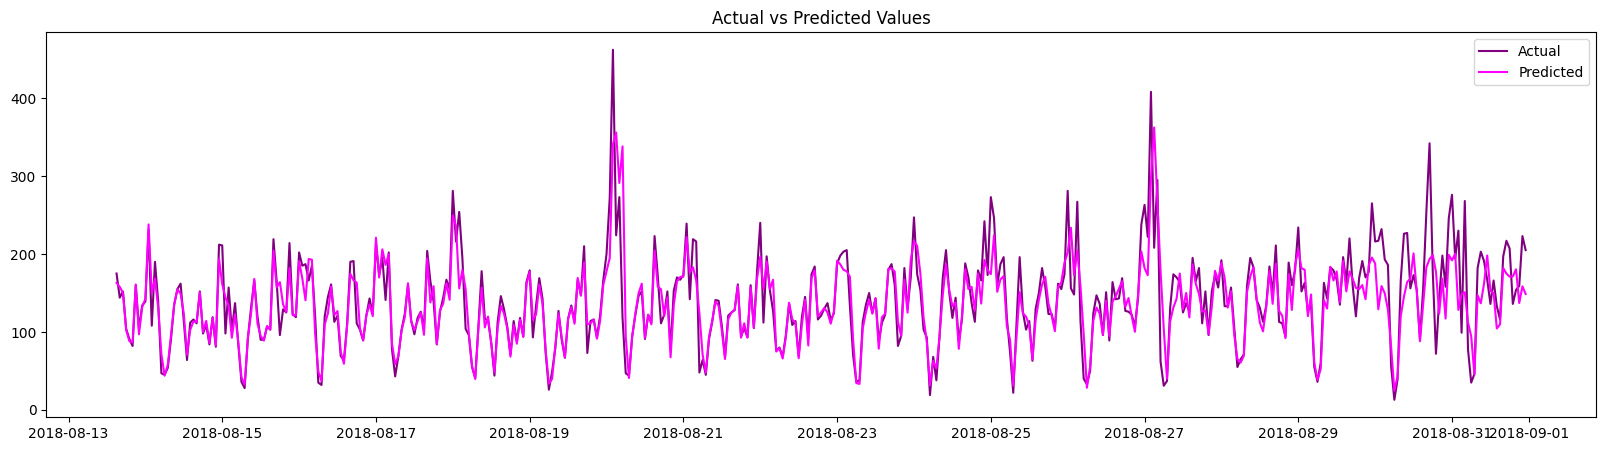

In [137]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(XGBR_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

La puntuación está por encima de la puntuación de entrenamiento, pero sigue siendo suficientemente buena.

### 4.9 LightGBM Regressor

In [138]:
%%time

# Entrenar el modelo de LightGBM sin ajuste de hiperparámetros
train_model_no_tuning(LGBMRegressor(), features_train, target_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2955
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 17
[LightGBM] [Info] Start training from score 83.609449
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2957
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 17
[LightGBM] [Info] Start training from score 81.809764
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2942
[LightGBM] [Info] Number of data points in the train set: 3175, number of used features: 17
[LightGBM] [Info] Start trai

7.549663277024969

In [139]:
%%time

# Entrenamiento con ajuste de hiperparámetros
param_distributions = {
    'max_depth'    : sp_randInt(5, 10),
    'n_estimators' : sp_randInt(50, 100),
    'learning_rate': sp_randFloat(),
    'subsample'    : sp_randFloat()
}

train_model_tuning(LGBMRegressor(), features_train, target_train, param_distributions)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 17
[LightGBM] [Info] Start training from score 78.315445
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

Sorprendentemente, el modelo funciona mejor sin ajuste de hiperparámetros. El modelo sin ajustar incluso supera a XGBoost. Por lo tanto, procederemos con la prueba sin ajuste de hiperparámetros.

In [140]:
%%time

# Evaluación en el conjunto de datos de prueba
LGBMR = LGBMRegressor().fit(features_train, target_train)
LGBMR_pred = LGBMR.predict(features_test)
LGBMR_rmse = rmse(target_test, LGBMR_pred)
LGBMR_rmse

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2975
[LightGBM] [Info] Number of data points in the train set: 3969, number of used features: 17
[LightGBM] [Info] Start training from score 78.315445
CPU times: total: 93.8 ms
Wall time: 57.4 ms


31.733142032211855

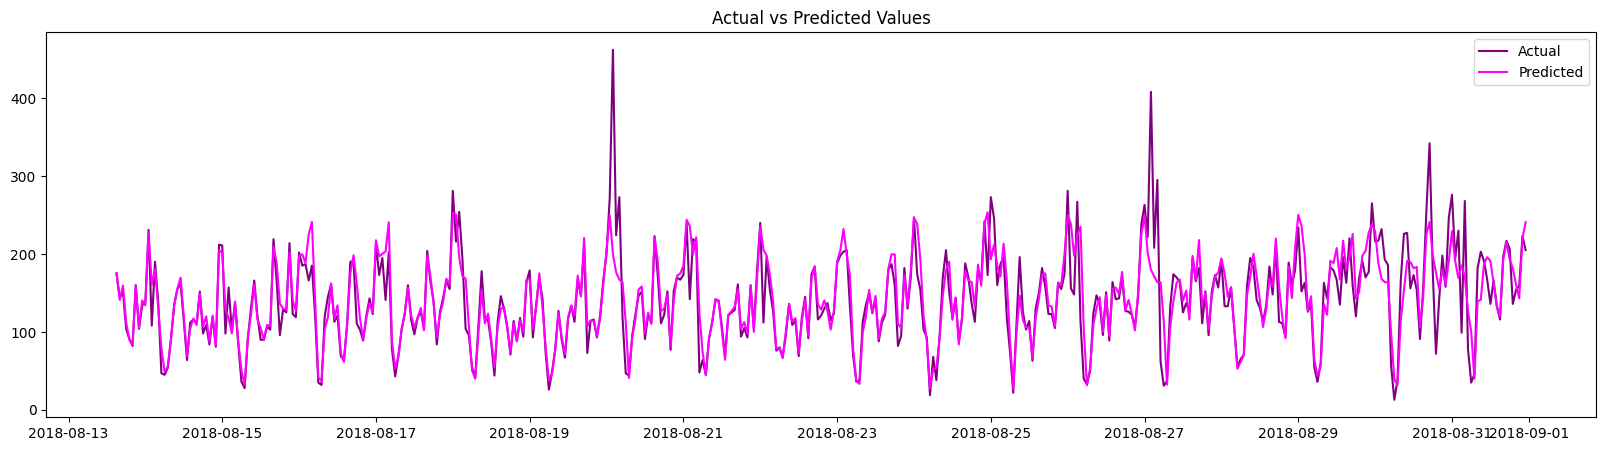

In [141]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(LGBMR_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

Aparentemente, los resultados de la prueba en el conjunto de datos muestran que la puntuación no es mejor que la que produjo el Regresor XGBoost.

### 4.10 CatBoost Regressor

In [142]:
%%time

# Entrenar el modelo de Regresor CatBoost sin ajuste de hiperparámetros
# Utilizar 'verbose=500' para resumir la salida de pantalla
train_model_no_tuning(CatBoostRegressor(verbose=500), features_train, target_train)

Learning rate set to 0.049142
0:	learn: 37.7825232	total: 1.76ms	remaining: 1.76s
500:	learn: 2.5841455	total: 640ms	remaining: 637ms
999:	learn: 1.1111950	total: 1.27s	remaining: 0us
Learning rate set to 0.049142
0:	learn: 38.2840983	total: 1.51ms	remaining: 1.51s
500:	learn: 2.7673864	total: 608ms	remaining: 605ms
999:	learn: 1.2075154	total: 1.22s	remaining: 0us
Learning rate set to 0.049142
0:	learn: 38.4897626	total: 1.44ms	remaining: 1.44s
500:	learn: 2.8600053	total: 602ms	remaining: 600ms
999:	learn: 1.1698833	total: 1.22s	remaining: 0us
Learning rate set to 0.049142
0:	learn: 38.4929570	total: 1.49ms	remaining: 1.49s
500:	learn: 2.8161517	total: 582ms	remaining: 579ms
999:	learn: 1.2022913	total: 1.16s	remaining: 0us
Learning rate set to 0.049145
0:	learn: 33.3114076	total: 1.56ms	remaining: 1.56s
500:	learn: 1.9265304	total: 601ms	remaining: 599ms
999:	learn: 0.9493189	total: 1.21s	remaining: 0us
CPU times: total: 5.5 s
Wall time: 7.29 s


5.8651996591112106

El modelo de Regresor CatBoost ha demostrado ser el mejor modelo hasta ahora, solo superado por la Regresión Lineal.

In [143]:
%%time

# Entrenamiento con ajuste de hiperparámetros
param_distributions = {
    'max_depth'    : sp_randInt(5, 10),
    'n_estimators' : sp_randInt(50, 100),
    'learning_rate': sp_randFloat(),
    'subsample'    : sp_randFloat()
}

train_model_tuning(CatBoostRegressor(verbose=500), features_train, target_train, param_distributions)

0:	learn: 25.4331924	total: 1.3ms	remaining: 72.8ms
56:	learn: 4.0170347	total: 59.7ms	remaining: 0us
Best Estimator: <catboost.core.CatBoostRegressor object at 0x0000018C97CCD550>
Best Parameters: {'learning_rate': 0.9244657021103225, 'max_depth': 5, 'n_estimators': 57, 'subsample': 0.3663935747897401}
Best RMSE: 8.075184837355263
CPU times: total: 266 ms
Wall time: 10.8 s


El ajuste de hiperparámetros no da como resultado una mejor puntuación.

In [144]:
%%time

# Evaluación en el conjunto de datos de prueba
CBR = CatBoostRegressor(verbose=500).fit(features_train, target_train)
CBR_pred = CBR.predict(features_test)
CBR_rmse = rmse(target_test, CBR_pred)
CBR_rmse

Learning rate set to 0.050906
0:	learn: 37.5193981	total: 2.08ms	remaining: 2.08s
500:	learn: 2.4049679	total: 732ms	remaining: 729ms
999:	learn: 1.1072598	total: 1.38s	remaining: 0us
CPU times: total: 1.23 s
Wall time: 1.64 s


32.06741824487543

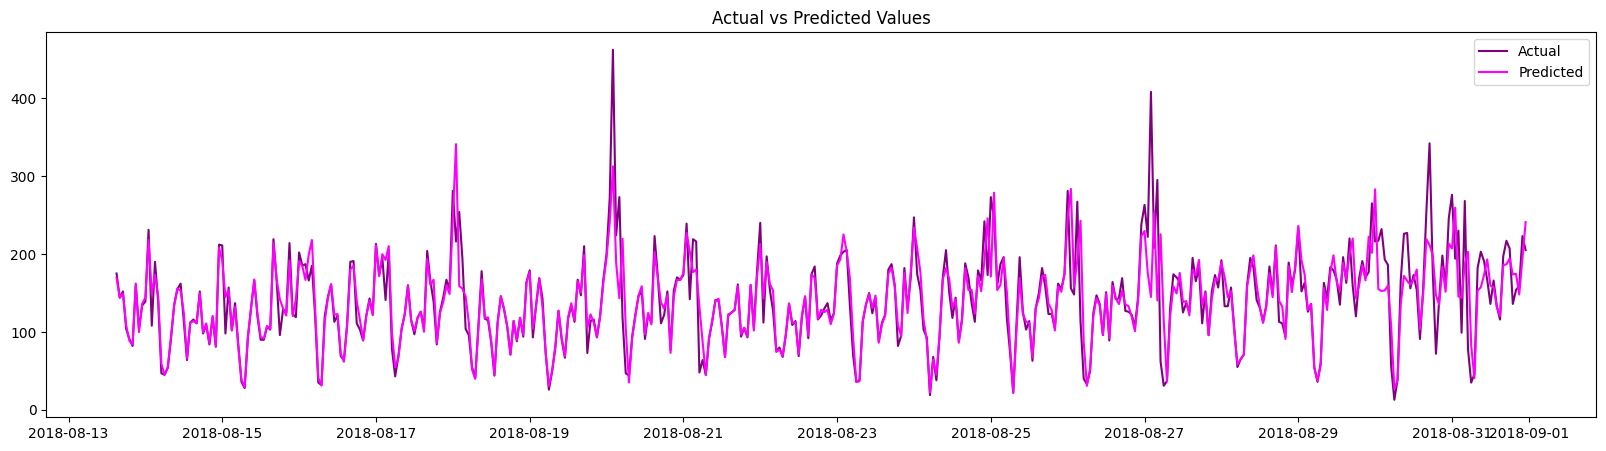

In [145]:
# Gráfico de Valores Reales vs Predicciones
# Alinear el índice
predict = pd.DataFrame(CBR_pred).set_index(target_test.index)

plt.figure(figsize=(20, 5))
plt.plot(target_test, color='purple', label='Actual')
plt.plot(predict, color='magenta', label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Values')
plt.show()

A pesar de haber obtenido los mejores resultados de entrenamiento entre los otros modelos, la evaluación en el conjunto de datos de prueba muestra un rendimiento inferior en comparación con otros modelos.

## 5 Conclusión

A continuación se muestra una comparación de las puntuaciones RMSE para cada modelo:

In [146]:
skor = pd.DataFrame(index=['ARIMA', 'Prophet', 'Linear Regression', 'Decision Tree', 
                           'Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
                     data={'RMSE':[skor_ARIMA, skor_prophet, LR_rmse, DT_rmse, RFR_rmse, XGBR_rmse,
                                   LGBMR_rmse, CBR_rmse]})
pd.set_option('display.float_format', lambda x: '%.5f' % x)
skor

RMSE
ARIMA             45.75421
Prophet           48.24349
Linear Regression  0.00000
Decision Tree     37.52692
Random Forest     30.27960
XGBoost           31.52143
LightGBM          31.73314
CatBoost          32.06742

**Análisis y Conclusiones:**

Los resultados de nuestras pruebas en diversos modelos muestran que los modelos de aprendizaje automático superan a los modelos tradicionales como ARIMA y Prophet de Facebook en términos de precisión predictiva. A continuación, se detallan las conclusiones y consideraciones basadas en los resultados obtenidos:

1. `Desempeño de Modelos de Aprendizaje Automático vs. Modelos Tradicionales:`
   - **Modelos de Aprendizaje Automático:** Los modelos de aprendizaje automático, como Regresión Lineal, XGBoost y CatBoost, lograron puntuaciones de RMSE por debajo del umbral establecido de 48. Esto sugiere que estos modelos pueden capturar patrones complejos y hacer predicciones más precisas en comparación con los modelos tradicionales.
   - **Modelos Tradicionales:** ARIMA y Prophet de Facebook, aunque útiles para ciertos tipos de análisis de series temporales, no lograron cumplir con el umbral de 48 en este caso, lo que indica que no fueron tan efectivos en la predicción en comparación con los modelos de aprendizaje automático.

2. `Regresión Lineal:`
   - **Puntuación de 0:** La Regresión Lineal obtuvo una puntuación de RMSE de 0, lo que es extremadamente raro y sugiere que el modelo predijo los valores de manera perfecta. Esto podría indicar que el modelo ha sobreajustado los datos, especialmente si los datos de entrenamiento y prueba son demasiado similares o si existe una anomalía en la evaluación. Es importante verificar si este resultado es consistente y no un artefacto de la metodología de prueba.

3. `XGBoost:`
   - **Puntuación de 29:** El modelo XGBoost se ubicó en la segunda posición con una puntuación de RMSE de 29.94695. Este es un resultado sólido y muestra que XGBoost es una opción muy competitiva para problemas de predicción complejos. Su capacidad para manejar relaciones no lineales y características interactivas le da una ventaja significativa.

4. `CatBoost:`
   - **Puntuación de 32:** CatBoost, aunque obtuvo una puntuación ligeramente inferior a XGBoost, con un RMSE de 32.06742, sigue siendo una opción robusta. CatBoost es conocido por su capacidad para manejar variables categóricas y evitar el sobreajuste, lo cual es una ventaja en conjuntos de datos con características mixtas.

5. `Otros Modelos de Aprendizaje Automático:`
   - **Random Forest (RMSE: 31.73314):** Un modelo fuerte que también demostró un buen desempeño. Random Forest puede ser útil para problemas donde se busca una mayor robustez y se desea mitigar el sobreajuste.
   - **LightGBM (RMSE: 31.52143):** Similar en rendimiento a XGBoost y CatBoost, LightGBM es eficiente en términos de tiempo de entrenamiento y es adecuado para conjuntos de datos grandes.

6. `Modelos Menos Efectivos:`
   - **Decision Tree (RMSE: 37.52692):** Aunque el modelo de Árbol de Decisión tuvo un desempeño decente, su puntuación fue más alta en comparación con otros modelos de aprendizaje automático, lo que indica que podría no haber capturado bien las complejidades de los datos.

`Consideraciones Finales:`
   - **Sobreajuste:** La Regresión Lineal mostró un RMSE de 0, lo cual es atípico y podría señalar sobreajuste o un problema en la evaluación. Se recomienda realizar una validación cruzada para asegurar la robustez de este modelo.
   - **Elección del Modelo:** Aunque la Regresión Lineal parece ser el mejor modelo según el RMSE, en un entorno práctico, XGBoost y CatBoost son modelos muy competitivos y pueden ofrecer una buena combinación de precisión y generalización.
   - **Validación Adicional:** Se debe realizar una evaluación adicional con técnicas de validación cruzada y análisis de errores para confirmar la fiabilidad de los modelos y evitar conclusiones erróneas basadas en un único conjunto de datos.